In [60]:
# this cell imports all the functions we need
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
%matplotlib inline 
# this is a "magic" function, which sets all our plots to inline. 
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython

In [11]:
# METADATA 
# this cell loads Suite2p configuration file "ops", and a "Timeline" structure with timings
mname, datexp, blk = 'TX42', '2019_06_04', '1' # this works! 

root = 'H:\CSHL_DATA'
fname = 'Timeline_%s_%s_%s'%(mname, datexp, blk) # this is one of the ways to make a formatted string
fnamepath = os.path.join(root, fname) # from the "path" sublibrary of "os", we use the function "join"
Timeline = io.loadmat(fnamepath, squeeze_me=True)['Timeline'] # here we combined two command "loadmat" with
# taking the "Timeline" field of the structure which loadmat returns. 

ops = np.load(os.path.join(root, 'suite2p', 'plane0', 'ops.npy'), allow_pickle=True).item() # ops is a "pickled" object,
# meaning it is not a simple numpy array. ".item()" is only necessary because ops is a Python dictionary, not a numpy array.

In [48]:
# NEURAL DATA

# we initialize empty variables
spks = np.zeros((0, ops['nframes']), np.float32) # the neural data will be Nneurons by Nframes. 
stat = np.zeros((0,)) # these are the per-neuron stats returned by suite2p
xpos, ypos = np.zeros((0,)) , np.zeros((0,)) # these are the neurons' 2D coordinates

# loop over planes and concatenate
for n in range(ops['nplanes']):
    ops = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'ops.npy'), allow_pickle=True).item()
    
    spks0 = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'spks.npy'))    
    stat0 = np.load(os.path.join(root, 'suite2p', 'plane%d'%n, 'stat.npy'), allow_pickle=True)
    ypos0 = np.array([stat0[n]['med'][0] for n in range(len(stat0))]) # notice the python list comprehension [X(n) for n in range(N)]
    xpos0 = np.array([stat0[n]['med'][1] for n in range(len(stat0))]) 
    
    ypos0 += ops['dy'] # add the per plane offsets (dy,dx)
    xpos0 += ops['dx']
    
    stat = np.concatenate((stat,stat0), axis=0)            
    spks = np.concatenate((spks,spks0), axis=0)            
    ypos = np.concatenate((ypos, ypos0), axis=0)
    xpos = np.concatenate((xpos, xpos0), axis=0)
    
    print('plane %d, '%n, 'neurons: %d'%spks0.shape[0])

print('total neurons %d'%len(stat))

plane 0,  neurons: 3262
plane 1,  neurons: 4037
plane 2,  neurons: 3921
plane 3,  neurons: 3510
total neurons 14730


Text(0, 0.5, 'Y position (um)')

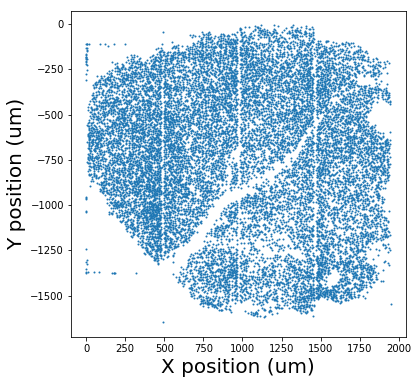

In [49]:
# POSITIONS OF ALL NEURONS
plt.figure(figsize=(6,6))
plt.scatter(xpos, -ypos, s = 1)
plt.xlabel('X position (um)', fontsize=20)
plt.ylabel('Y position (um)', fontsize=20)

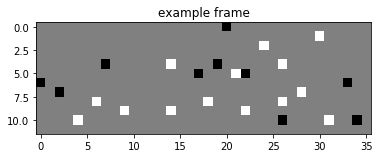

In [50]:
# STIMULUS FRAME
plt.figure()
plt.imshow(mov[:,:,100], cmap='gray')
plt.title('example frame')
plt.show()

Text(0.5, 0, 'time points')

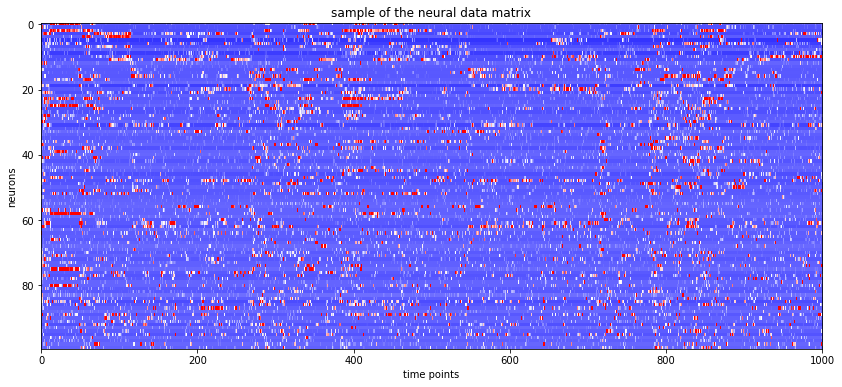

In [84]:
plt.figure(figsize=(14,6))
plt.imshow(S[:100, :1000], vmax = 3, vmin = -1, aspect='auto', cmap = 'bwr')
plt.title('sample of the neural data matrix')
plt.ylabel('neurons')
plt.xlabel('time points')

In [ ]:
mov = Timeline['mov'].item() # mov contains the sparse noise frames
iframe = Timeline['stiminfo'].item()['frame_start'].astype('int') # iframe[n] is the microscope frame for the image frame n

dt = 1 # time offset 
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
mov = mov[:, :, ivalid]
S = spks[:, iframe+dt]

deltay = ypos[:, np.newaxis] - ypos # np.newaxis creates a new axis
deltax = xpos[:, np.newaxis] - xpos # a vector of N by 1 can broadcast with a vector of 1 by N to give a matrix N by N

ds = (deltay**2 + deltax**2)**.5 # **2 means elementwise squaring

S = stats.zscore(S, axis=1) # z-score the neural activity before doing anything

In [61]:
# THIS CELL runs RASTERMAP 
from rastermap import Rastermap
model = Rastermap(n_components=1, n_X=100).fit(S) 

nmin 200
1.0641558170318604
29.392411947250366
30.77870512008667
30.82557964324951
(98, 100)
(130,)
1.0
time; iteration;  explained PC variance
0.58s     0        0.0193      2
1.07s    10        0.1217      4
1.56s    20        0.1545      8
2.05s    30        0.1988      18
2.53s    40        0.2249      28
3.02s    50        0.2445      38
3.51s    60        0.2637      48
3.99s    70        0.2797      58
4.47s    80        0.2926      68
4.95s    90        0.3055      78
5.43s    100        0.3173      88
5.91s    110        0.3281      98
6.41s    120        0.3296      98
6.85s   final      0.3306
6.87s upsampled    0.3306


In [74]:
from scipy.ndimage import gaussian_filter1d
isort = np.argsort(model.embedding[:,0])

Sfilt = gaussian_filter1d(S[isort, :], 20, axis=0)
Sfilt = zscore(Sfilt, axis=1)

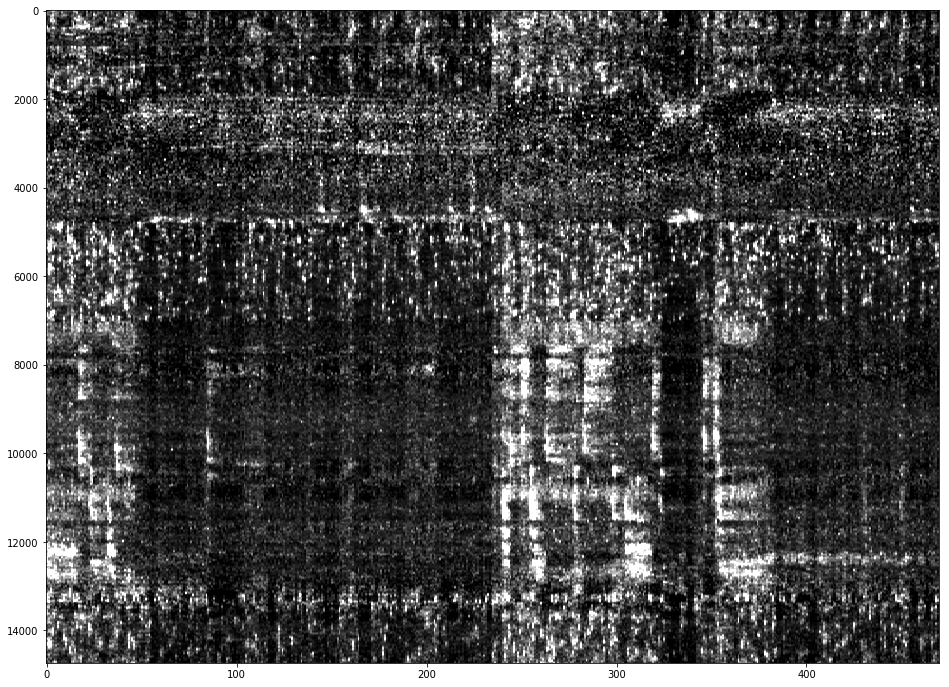

In [81]:
plt.figure(figsize=(16,12))
plt.imshow(Sfilt[:, 30:500], vmin = -1, vmax=3, aspect='auto', cmap = 'gray')
plt.show()

In [52]:
NN, NT = S.shape 

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = np.abs(X-0.5) # does not matter if a pixel is black (0) or white (1)
X = stats.zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.01 # regularizer for ridge regression
B0 = np.linalg.solve((X @ X.T + lam * np.eye(npix)),  (X @ S.T)) # get the receptive fields for each neuron

if datexp is '2019_06_04' or datexp is '2019_06_06': # on these dates, the screens were flipped! 
    B0 = np.reshape(B0, [mov.shape[0], 2, int(mov.shape[1]/2), NN])
    B0 = np.flip(B0, axis=1)
        
B0 = np.reshape(B0, [mov.shape[0], mov.shape[1], NN])
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

sig = 50 # spatial scale for smoothing
B = np.zeros(B0.shape)
for j in range(NN):
    ix = ds[:,j]<sig
    B[:,:,j] = np.mean(B0[:,:,ix], axis=-1) # average receptive fields within sig
    
Amax = np.max(np.max(B, axis=0), axis=0) # maximum response to preferred stimulus

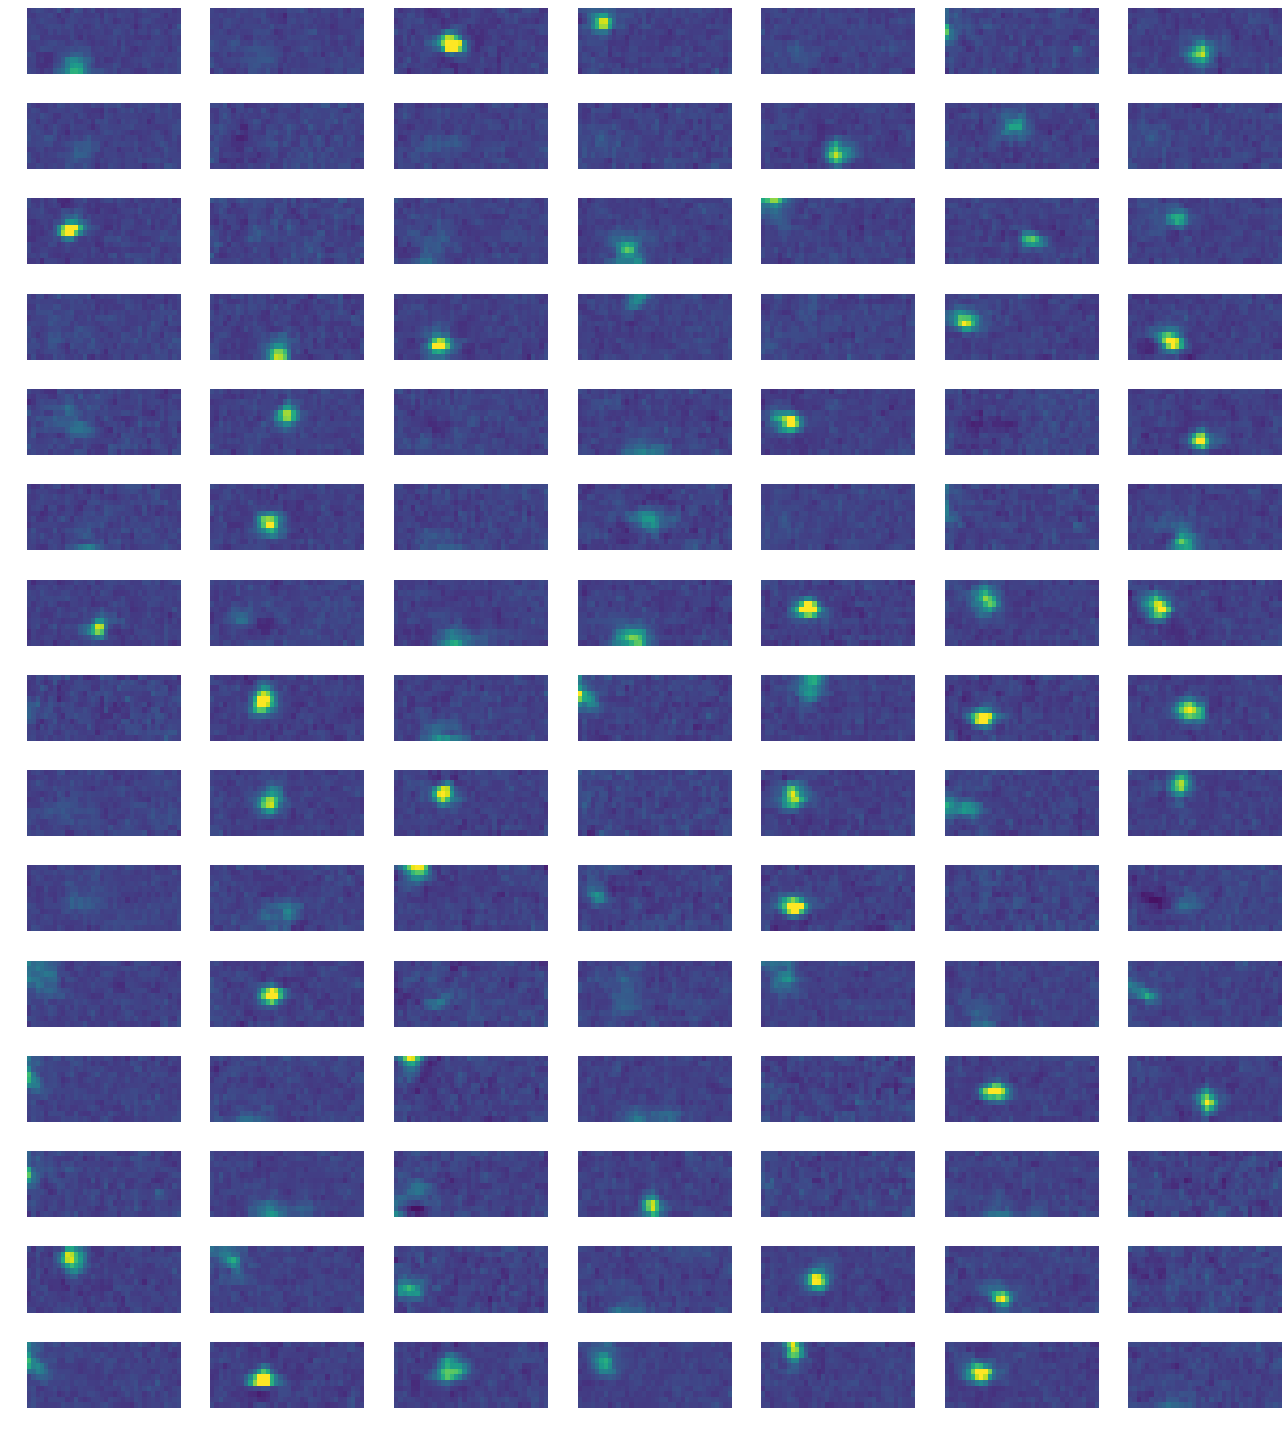

In [53]:
plt.figure(figsize=(18, 20))
np.random.seed(101) # set the seed for the random number generator, so that our random samples are reproducible
rperm = np.random.permutation(NN) # choose a random set of neurons

for j in range(7*15):
    plt.subplot(15,7,j+1)
    plt.imshow(B[:,:,rperm[j]], aspect='auto', vmin=-1, vmax=4) # plot the receptive field for each neuron
    plt.axis('off')
    
plt.tight_layout() # make a nice layout of the subplots
plt.show()

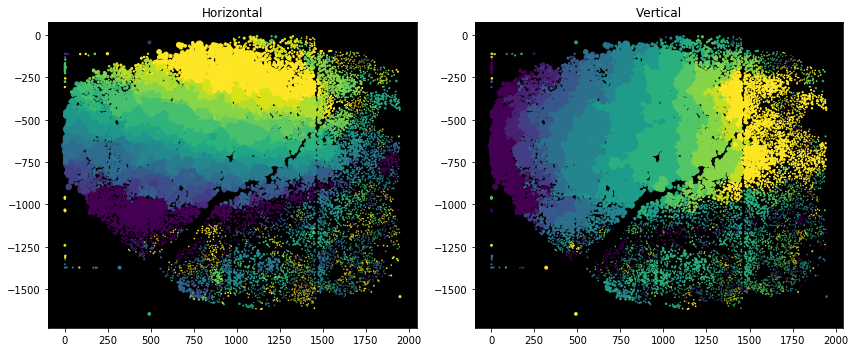

In [54]:
imax = np.argmax(np.reshape(B, [-1,NN]), axis=0) # find the pixel corresponding to the max response for each cell
ly, lx, nstim = mov.shape

# xmax, ymax = np.unravel(imax, (ly, lx)) # unravel an index for a (1,ly*lx) array, to two indices for an (ly, lx) array
xmax = np.minimum(17, imax%lx)
ymax = (imax/lx).astype('int')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1, facecolor=[0, 0, 0])
plt.scatter(xpos, -ypos, s = (Amax)**2, c = xmax, cmap='viridis')
plt.title('Horizontal')

plt.subplot(1,2,2, facecolor=[0, 0, 0])
plt.scatter(xpos, -ypos, s = (Amax)**2, c = ymax, cmap='viridis')
plt.title('Vertical')

plt.tight_layout()

plt.show()

In [15]:
#def upsampling_mat(Ly, Lx, upfactor = 10, sig = 1):
Ly, Lx, NN = B.shape
sig = 1
upfactor = 10
xs,ys  = np.meshgrid(np.arange(Lx), np.arange(Ly))
xs = xs.flatten()
ys = ys.flatten()
ds = (xs[:, np.newaxis] - xs)**2 + (ys[:, np.newaxis] - ys)**2
Kxx = np.exp(-ds/(2*sig**2))

Xs,Ys  = np.meshgrid(np.linspace(0, Lx, 1 + upfactor*Lx)[:-1], np.linspace(0, Ly, 1 + upfactor*Ly)[:-1])
Xs, Ys = Xs.flatten(), Ys.flatten()
dd = (Xs[:, np.newaxis] - xs)**2 + (Ys[:, np.newaxis] - ys)**2
Kyx = np.exp(-dd/(2*sig**2))
Kup = np.linalg.solve(Kxx, Kyx.T)

In [16]:
Bup = Kup.T @ np.reshape(B, (-1, NN))
Bup = np.reshape(Bup, (Ly * upfactor, Lx * upfactor, NN))

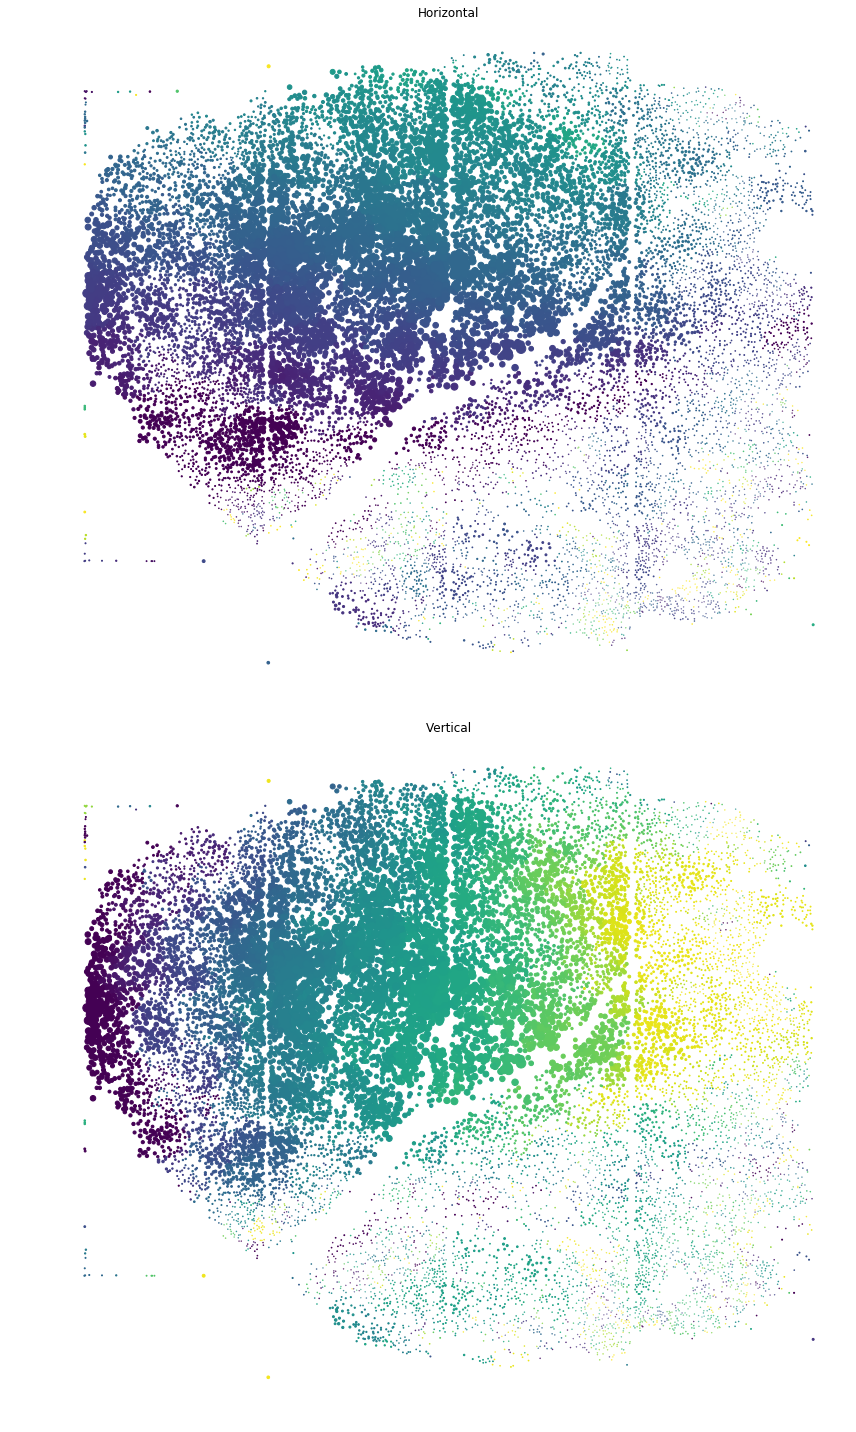

In [18]:
imax = np.argmax(np.reshape(Bup, [-1,NN]), axis=0)
ly, lx, _ = Bup.shape
xmax = imax%lx
ymax = (imax/lx).astype('int')


plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.scatter(xpos, -ypos, s = (Amax/1)**2, c = xmax, cmap='viridis')
#plt.scatter(xpos, -ypos, s = 4, c = Amax, cmap='viridis')
plt.title('Horizontal')
plt.axis('off')
plt.subplot(2,1,2)
plt.scatter(xpos, -ypos, s = (Amax/1)**2, c = ymax, cmap='viridis')
plt.title('Vertical')
plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
imax = np.argmax(np.reshape(Bup, [-1,NN]), axis=0)
ly, lx, _ = Bup.shape
xmax = imax%lx
ymax = (imax/lx).astype('int')

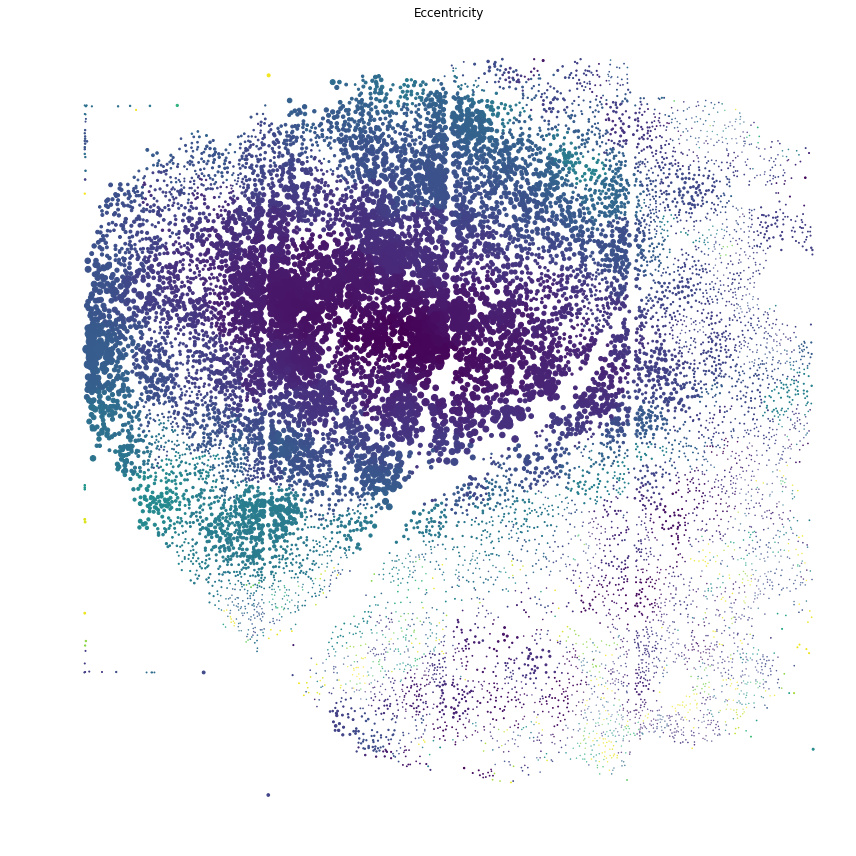

In [20]:
xmax = xmax- np.mean(xmax)
ymax = ymax - np.mean(ymax)
ecc = (xmax**2 + ymax**2)**.5

plt.figure(figsize=(12,12))
plt.scatter(xpos, -ypos, s = (Amax)**2, c = ecc, cmap='viridis')
plt.title('Eccentricity')
plt.axis('off')

plt.tight_layout()
plt.show()